In [1]:
import quaternion as qu
import matplotlib.pyplot as plt
import numpy as np
from sdf.sdf.d3 import sphere, torus, slab
from importlib import reload
from sdf.sdf import d3

from fractal_printer import REPO_ROOT
output_dir = REPO_ROOT / "outputs"

In [2]:

def mag2(z):
    return np.abs(z)**2

@d3.sdf3
def quaternion_julia_sdf(c, n = 2, iterations = 50, bailout_level = 10000**2, offset=0):

    def distance(p):
        # Convert starting points to quaterinons
        z = qu.from_float_array(
            np.concatenate(
                (p,np.zeros((p.shape[:-1]+(1,)))),
                axis=1
            )
        )

        # Define helper arrays
        z2 = mag2(z)                                    # Current mag^2 of tracked point
        zp2 =         np.ones(p.shape[:-1],dtype=float) # Current mag^2 of derivative
        bailout =     np.zeros(p.shape[:-1],dtype=bool) # Mask of points that have crossed the bailout threshold
        new_bailout = np.zeros(p.shape[:-1],dtype=bool) # Mask of points that have crossed the bailout threshold this iteration

        for _ in range(iterations):
            # Update points
            zp2[~bailout] = n*n*z2[~bailout]*zp2[~bailout]
            z[~bailout] = z[~bailout]**n + c
            z2[~bailout] = mag2(z[~bailout])

            # Update mask
            new_bailout = (z2 > bailout_level) & ~bailout
            bailout = bailout | new_bailout

        dist = np.sqrt(z2/zp2)*0.5*np.log(z2)
        return dist - offset

    return distance

[[22.96198399]
 [23.0742056 ]]
[-0.55551102 -1.2         0.        ]


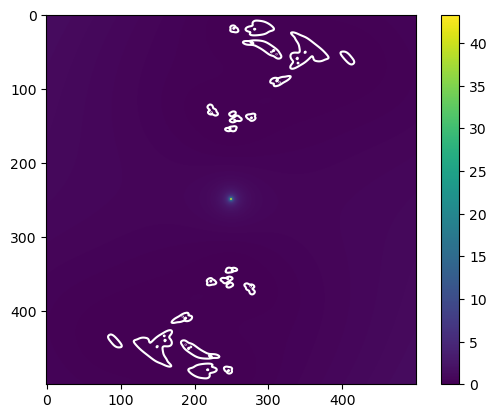

In [59]:
# Make construct an sdf estimator for a 3D julia set
julia_sdf = quaternion_julia_sdf(qu.quaternion(0.2,0.7,-0.5,0.7),iterations=60, offset=0.01)

# Test it
p = np.array([[0,10,0],[10,0,0]])
print(julia_sdf(p))

# Use the SDF to make a 2d rendering of the julia set
points = 500
radius = 1.2
x = np.linspace(-radius,radius,points)
y = np.linspace(-radius,radius,points)

X,Y = np.meshgrid(x, y, indexing="xy")

p = np.vstack((X.flatten(), Y.flatten(), np.zeros_like(X).flatten())).T
print(p[134])
d = julia_sdf(p)

# Plot it!
D = d.reshape((points,points))

im = plt.imshow(np.clip(D,0,None))
plt.contour(D,levels=[0],colors="w")
plt.colorbar(im)

In [62]:
# Generate mesh
import meshio

radius = 1.4
raw_points = points = julia_sdf.generate(bounds = ([-radius]*3,[radius]*3), samples=2**28)
points, cells = np.unique(raw_points, axis=0, return_inverse=True)
cells = [('triangle', cells.reshape((-1, 3)))]
mesh = meshio.Mesh(points, cells)


min -1.4, -1.4, -1.4
max 1.4, 1.4, 1.4
step 0.00434055, 0.00434055, 0.00434055
295408296 samples in 9261 batches with 8 workers
  100% (9261 of 9261) [##############################] 0:01:01 0:00:00    
8034 skipped, 336 empty, 891 nonempty
3063422 triangles in 61.3888 seconds


In [63]:
# Save the raw mesh for inspection
meshio.write(output_dir / "julia.ply", mesh, binary=True)

Warning: PLY doesn't support 64-bit integers. Casting down to 32-bit.

(10, 3)
Refinement iteration 0
new points:  (332664, 3)
f (332664, 1)
f_plus:  (332664, 3)
grad:  (332664, 3)
Refinement iteration 1
new points:  (332664, 3)
f (332664, 1)
f_plus:  (332664, 3)
grad:  (332664, 3)
Refinement iteration 2
new points:  (332664, 3)
f (332664, 1)
f_plus:  (332664, 3)
grad:  (332664, 3)
Refinement iteration 3
new points:  (332664, 3)
f (332664, 1)
f_plus:  (332664, 3)
grad:  (332664, 3)
Refinement iteration 4
new points:  (332664, 3)
f (332664, 1)
f_plus:  (332664, 3)
grad:  (332664, 3)


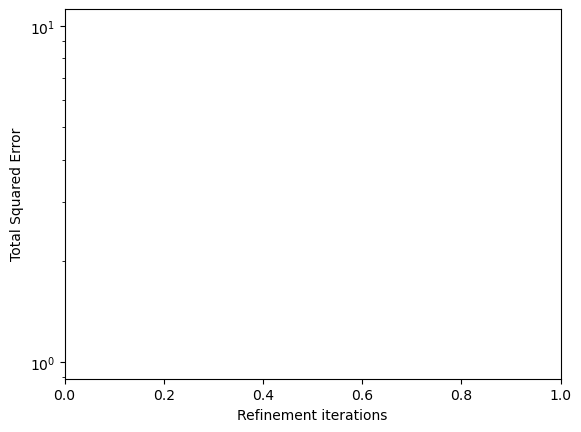

In [ ]:
# Refine mesh with newton steps
refined_points = np.array(points).copy()
print(refined_points.shape)

def gradient(r, f, epsilon=1e-3):
    gx = (f(r + np.array([epsilon,0,0])) - f(r - np.array([epsilon,0,0]))) / (2*epsilon)
    gy = (f(r + np.array([0,epsilon,0])) - f(r - np.array([0,epsilon,0]))) / (2*epsilon)
    gz = (f(r + np.array([0,0,epsilon])) - f(r - np.array([0,0,epsilon]))) / (2*epsilon)
    return np.hstack((gx, gy, gz))

def gradient_vectorized(points, sdf, epsilon=1e-3):

    # points: (N,3)
    eps = np.eye(3) * epsilon  # (3,3)
    f_plus = np.hstack([sdf(points + eps[i]) for i in range(3)])  # (N,3)
    f_minus = np.hstack([sdf(points - eps[i]) for i in range(3)])  # (N,3)
    grad = (f_plus - f_minus) / (2*epsilon)
    return grad

def refine_points(points, distance_function, steps = 1, epsilon=1e-8):
    new_points = points.copy()
    print("new points: ", new_points.shape)
    for _ in range(steps):
        f = distance_function(new_points)
        grad = gradient_vectorized(new_points, distance_function, epsilon=epsilon) 
        new_points = new_points - f * grad / np.sum(grad*grad,axis=-1)[:,np.newaxis] * 0.5

    return new_points

def error(points, distance_function):
    f = distance_function(points)
    return np.sum(f*f)

fig, ax = plt.subplots(1,1)
ax.set_yscale("log")
ax.set_ylabel("Total Squared Error")
ax.set_xlabel("Refinement iterations")

for i in range(5):
    print(f"Refinement iteration {i}")
    mesh.points = refine_points(mesh.points, julia_sdf, epsilon=1e-5)
    meshio.write(output_dir / f"julia_{i}.ply", mesh, binary=True)

In [53]:
eps = np.eye(3) * 0.1  # (3,3)
points = np.random.randn(10,3)
print(points.shape)

foo = julia_sdf(points + eps[0])
print(foo.shape)
# forward differences
f_plus = np.hstack([julia_sdf(points + eps[i]) for i in range(3)])  # (N,3)
print(f_plus.shape)

(10, 3)
(10, 1)
(10, 3)


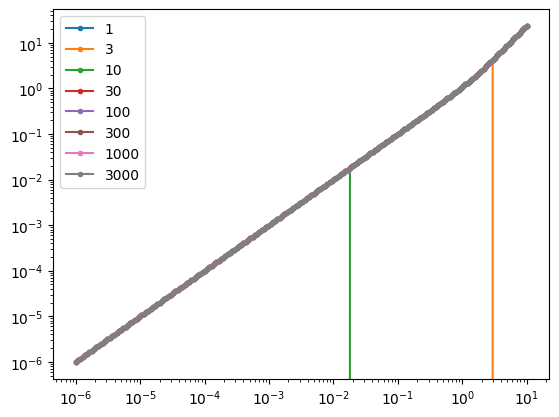

In [ ]:
# Test convergence with iteration count

fig, ax = plt.subplots(1,1)

ax.set_xscale("log")
ax.set_yscale("log")
y = np.geomspace(1e-6,1e1,200)
points = np.vstack((np.zeros_like(y),y,np.zeros_like(y))).T

for iterations in [1,3,10,30,100,300,1000,3000]:
    line_julia = df.generalized_mandelbrot(cx=-2, iterations=iterations, offset=0)

    distance = line_julia(points)

    ax.plot(y,distance,".-",label=iterations)

ax.legend()



min -1.2, -1.2, -1.2
max 1.2, 1.2, 1.2
step 0.009375, 0.009375, 0.009375
18191447 samples in 512 batches with 8 workers
  100% (512 of 512) [##############################] 0:00:21 0:00:00    
194 skipped, 20 empty, 298 nonempty
2098648 triangles in 21.033 seconds
 
*** Profile stats marshalled to file '/tmp/tmpp4qo3hde'.
Embedding SnakeViz in this document...
<function display at 0x7c80911a4680>


In [ ]:
# Export a sliced 3D rendering
sectioned_julia = julia_sdf & slab(z0 = 0)
sectioned_julia.save("sectioned_julia.stl",bounds = ([-radius]*3,[radius]*3), samples=2**24)

min -1.2, -1.2, -1.2
max 1.2, 1.2, 1.2
step 0.009375, 0.009375, 0.009375
18191447 samples in 512 batches with 8 workers
  100% (512 of 512) [##############################] 0:00:15 0:00:00    
311 skipped, 52 empty, 149 nonempty
1064428 triangles in 15.0831 seconds
